In [1]:
import torch
from google.colab import drive

# Check GPU
print("Torch CUDA available:", torch.cuda.is_available())
!nvidia-smi

# Mount Google Drive
drive.mount('/content/drive')

Torch CUDA available: True
Sat Nov 29 00:20:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------

In [2]:
!pip install -q "transformers>=4.41.0" "accelerate>=0.30.0" \
  peft bitsandbytes datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 38.3 MB/s eta 0:00:00


In [3]:
from pathlib import Path

# If your dataset is in: MyDrive/train_qwen_milp_italy.jsonl
DATA_PATH = "/content/drive/MyDrive/Energy Arbitrage Agentics/dataset_qwen_train.jsonl"

# Or, if you put it in "Colab Notebooks" folder, use:
# DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/train_qwen_milp_italy.jsonl"

OUTPUT_DIR = "/content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_qlora_test2"  # adapter will be saved here

MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B"

# Training hyperparams (you can tweak later)
NUM_TRAIN_EPOCHS = 1.0       # start with 0.3–0.5 for a quick test if you want
BATCH_SIZE = 1                  # number of sequences processed simultaneously per GPU step. Qwen2.5-Math-7B is a large model, GPU memory on colab is not large, batch size of 1 safest
GRAD_ACC_STEPS = 4              # effective batch size = BATCH_SIZE * GRAD_ACCumulation_STEPS - 8 sequences per update
LEARNING_RATE = 2e-4            # controls the step size when updating LoRA weights
MAX_LENGTH = 2048               # 4096 may be too heavy on T4; 2048 is safer : problem + solution + system prompt after tokenization.
VAL_SPLIT = 0.05                # 5% for validation

print("DATA_PATH:", DATA_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("MODEL_NAME:", MODEL_NAME)


DATA_PATH: /content/drive/MyDrive/Energy Arbitrage Agentics/dataset_qwen_train.jsonl
OUTPUT_DIR: /content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_qlora_test2
MODEL_NAME: Qwen/Qwen2.5-Math-1.5B


In [4]:
#  Load Qwen2.5-Math-1.5B with 4-bit (QLoRA setup)

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

from peft import ( #parameter efficient fine tuning
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# 1. Tokenizer : loads the tokenizer that matches Qwen2.5-Math-7B. The tokenizer transforms your text into tokens (integers) and back.
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, #Qwen math model
    trust_remote_code=True,
)
if tokenizer.pad_token is None: #Many decoder-only models (like Qwen) don’t have a dedicated padding token. But during training with batches, we need to pad sequences to the same length.
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# 2. 4-bit quantization config for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Load the model weights in 4-bit quantized form instead of fp16/fp32.
                        # This reduces memory hugely:
                        # 7B params * 4 bits ≈ 3.5 GB
                        # (plus overhead, activations, etc.)
    bnb_4bit_use_double_quant=True, # First compress weights using 4-bit; then compress the scale factors too.
    bnb_4bit_quant_type="nf4", # NormalFloat4 to keep information loss low, especially for models pretrained in fp16
    bnb_4bit_compute_dtype=torch.bfloat16,  # Even though weights are stored in 4 bits, Computations (matrix multiplications, etc.) are done in bfloat16.
)

print("Loading base model in 4-bit (this may take a bit)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, # downloads the model
    quantization_config=bnb_config, # applies the bits and buytes config
    device_map="auto", # automatically shards/places layers across available GPUs
    trust_remote_code=True,
)
print(" You will now have a full 7B model in memory in 4 bits, which fits on a Colab GPU.....")

model.config.use_cache = False

# 3. Prepare for k-bit training + apply LoRA on attention/FFN blocks
print("We’re going to now train tiny LoRA modules on top of this 4-bit-frozen backbone using PEFT. Prepare the backbone accordingly....")
model = prepare_model_for_kbit_training(model) # We’re going to train tiny LoRA modules on top of this 4-bit-frozen backbone. Prepare the backbone accordingly.

lora_config = LoraConfig(
    r=16, # rank of the low-rank update. Higher r more capacity more parameters.
    lora_alpha=16, # scaling factor applied to the lora update W  = W + \alpha /r BA, scale of 1
    lora_dropout=0.05,
    bias="none", # Don’t add trainable bias terms in the LoRA layers.
    task_type="CAUSAL_LM", # a causal language modeling task (left-to-right LLM).
    target_modules=[ # where do we inject LoRA?
        "q_proj", # query
        "k_proj", # key
        "v_proj", # value
        "o_proj", # output
        "gate_proj", # main linear lauers in feedforward MLP blocks
        "up_proj", #main linear lauers in feedforward MLP blocks
        "down_proj",#main linear lauers in feedforward MLP blocks
    ],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading base model in 4-bit (this may take a bit)...


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

 You will now have a full 7B model in memory in 4 bits, which fits on a Colab GPU.....
We’re going to now train tiny LoRA modules on top of this 4-bit-frozen backbone using PEFT. Prepare the backbone accordingly....
trainable params: 18,464,768 || all params: 1,562,179,072 || trainable%: 1.1820


In [5]:
import ast
# d = ast.literal_eval(raw_dataset[0]["output"])
# d["soc"]



In [6]:
# Load dataset and map to ChatML-style text

from datasets import load_dataset

# Load JSONL with lines: {"problem": "...", "solution": "..."}
raw_dataset = load_dataset(
    "json",
    data_files={"train": DATA_PATH},
)["train"]

print("Total examples:", len(raw_dataset))

SYSTEM_PROMPT = """\
You are a battery arbitrage optimization engine that exactly emulates the following mixed-integer linear program (MILP).

Given data:
- prices_buy[t]  : buy price at time t  (EUR/MWh)
- prices_sell[t] : sell price at time t (EUR/MWh), or equal to prices_buy[t] if missing
- demand_MW[t]   : exogenous load at time t (MW)
- capacity_MWh: energy capacity of the battery (MWh)
- max_c_MW: maximum charge power (MW)
- max_d_MW: maximum discharge power (MW)
- eta_c: charge efficiency
- eta_d: discharge efficiency
- soc0: initial SoC (fraction of capacity, between 0 and 1)
- soc_min, soc_max: SoC limits (fractions, between 0 and 1)
- dt_hours: time step length in hours
- allow_export: whether the battery can export to the grid

Horizon:
- There are T time steps, indexed t = 0,...,T-1, where T = 24 currently.
- Each step has length dt_hours (in hours), which is 1 currently.

Decision variables (for each t = 0,...,T-1):
- c[t]   >= 0 : charge power (MW)
- d[t]   >= 0 : discharge power (MW)
- imp[t] >= 0 : net import from grid (MW)
- exp[t] >= 0 : net export to grid (MW), only if allow_export = true
- y_c[t] in {0,1} : binary indicator for charging
- y_d[t] in {0,1} : binary indicator for discharging

State variable:
- SOC[t] : state of charge at time t (fraction in [0,1]), for t = 0,...,T
- SOC[0] = soc0.

Dynamics (for all t = 0,...,T-1):
- SOC[t+1] = SOC[t] + (eta_c * c[t] * dt_hours - d[t] * dt_hours / eta_d) / capacity_MWh

Constraints (for all t = 0,...,T-1):
- 0 <= c[t] <= max_c_MW * y_c[t]
- 0 <= d[t] <= max_d_MW * y_d[t]
- y_c[t] + y_d[t] <= 1              # cannot charge and discharge simultaneously
- soc_min <= SOC[t] <= soc_max
- soc_min <= SOC[T] <= soc_max

Power balance:
- Let net[t] = demand_MW[t] + c[t] - d[t].
  imp[t] - exp[t] == net[t]
  (imp can be positive or export can be positive so that net load is met.)

Objective:
minimize  sum_t [ prices_buy[t] * imp[t] * dt_hours
                      - prices_sell[t] * exp[t] * dt_hours ]


Your task:
Given the instance data (battery parameters, dt_hours, allow_export, prices_buy, prices_sell, demand_MW) from the user, you must replicate the optimal MILP solution and return:

- The full SoC trajectory SOC[0..T] as a list of T+1 floats in [soc_min, soc_max].
- The optimal total cost value of the objective.

Output format:
Return ONLY a single JSON object with the following keys:
{
  "soc": [SOC_0, SOC_1, ..., SOC_T],
  "cost": <float optimal_cost>
}

Do NOT include explanations, comments, or text outside this JSON.
"""

def to_chatml(example):
    user_message = example["user_message"]
    # input_message = example["input"]
    assistant_message = example["assistant_message"]
    # output_message = example["output"]
    EOS_TOKEN = tokenizer.eos_token
    text = (
        "<|im_start|>system\n"
        + SYSTEM_PROMPT
        + "<|im_end|>\n"
        "<|im_start|>user\n"
        + user_message
        + "<|im_end|>\n"
        "<|im_start|>assistant\n"
        + assistant_message
        + EOS_TOKEN
    )
    return {"text": text}

chatml_dataset = raw_dataset.map(to_chatml)
chatml_dataset[0]["text"][:1000]


Generating train split: 0 examples [00:00, ? examples/s]

Total examples: 1094


Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

'<|im_start|>system\nYou are a battery arbitrage optimization engine that exactly emulates the following mixed-integer linear program (MILP).\n\nGiven data:\n- prices_buy[t]  : buy price at time t  (EUR/MWh)\n- prices_sell[t] : sell price at time t (EUR/MWh), or equal to prices_buy[t] if missing\n- demand_MW[t]   : exogenous load at time t (MW)\n- capacity_MWh: energy capacity of the battery (MWh)\n- max_c_MW: maximum charge power (MW)\n- max_d_MW: maximum discharge power (MW)\n- eta_c: charge efficiency\n- eta_d: discharge efficiency\n- soc0: initial SoC (fraction of capacity, between 0 and 1)\n- soc_min, soc_max: SoC limits (fractions, between 0 and 1)\n- dt_hours: time step length in hours\n- allow_export: whether the battery can export to the grid\n\nHorizon:\n- There are T time steps, indexed t = 0,...,T-1, where T = 24 currently.\n- Each step has length dt_hours (in hours), which is 1 currently.\n\nDecision variables (for each t = 0,...,T-1):\n- c[t]   >= 0 : charge power (MW)\n-

In [7]:
tokenizer.eos_token, tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|im_end|>")

('<|endoftext|>', 151643, 151645)

In [8]:
raw_dataset[0]

{'date': datetime.datetime(2018, 1, 1, 0, 0),
 'user_message': '{"capacity_MWh":49.44,"max_c_MW":12.36,"max_d_MW":12.36,"eta_c":0.95,"eta_d":0.95,"soc0":0.5,"soc_min":0.0,"soc_max":1.0,"dt_hours":1.0,"allow_export":true,"prices_buy":[45.82,44.16,42.24,39.29,36.0,41.99,42.25,44.97,45.0,44.94,45.02,45.71,46.7,43.98,44.96,47.53,49.91,54.3,51.91,51.38,49.2,45.73,44.84,38.11],"prices_sell":[45.82,44.16,42.24,39.29,36.0,41.99,42.25,44.97,45.0,44.94,45.02,45.71,46.7,43.98,44.96,47.53,49.91,54.3,51.91,51.38,49.2,45.73,44.84,38.11],"demand_MW":[22.98,21.81,20.76,19.97,19.49,19.84,21.1,22.1,22.4,23.59,24.37,24.96,25.06,23.9,23.49,23.76,25.24,29.1,30.35,30.97,30.34,28.82,26.54,24.05]}',
 'assistant_message': '{"soc":[0.5,0.5,0.5,0.5,0.7375,0.9750000000000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7894736842105263,0.5263157894736842,0.2631578947368421,0.0,0.0,0.0,0.0,0.0],"cost":25278.39562}'}

In [9]:
chatml_dataset[0]["text"][-300:]

'.9,23.49,23.76,25.24,29.1,30.35,30.97,30.34,28.82,26.54,24.05]}<|im_end|>\n<|im_start|>assistant\n{"soc":[0.5,0.5,0.5,0.5,0.7375,0.9750000000000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7894736842105263,0.5263157894736842,0.2631578947368421,0.0,0.0,0.0,0.0,0.0],"cost":25278.39562}<|endoftext|>'

In [10]:
lengths = []

for i, ex in enumerate(chatml_dataset):
    # ex["text"] contains ChatML formatted prompt + solution
    tokens = tokenizer.encode(ex["text"])
    lengths.append((i, len(tokens)))

# Show first 10 lengths
len(lengths)

1094

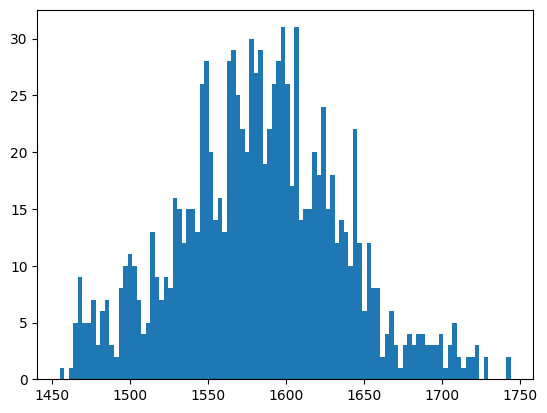

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
lengths = np.array(lengths)[:,1]
plt.hist(lengths, bins=100)
plt.show()

In [12]:
low_threshold = MAX_LENGTH
np.sum(lengths < low_threshold)

np.int64(1094)

In [13]:
# Split into train/val and tokenize

from transformers import DataCollatorForLanguageModeling

# Train/Val split
if VAL_SPLIT > 0.0:
    split = chatml_dataset.train_test_split(test_size=VAL_SPLIT, seed=42)
    train_dataset = split["train"]
    eval_dataset = split["test"]
else:
    train_dataset = chatml_dataset
    eval_dataset = None

print("Train size:", len(train_dataset))
if eval_dataset is not None:
    print("Val size:", len(eval_dataset))

# Tokenization function
ASSISTANT_HEADER = "<|im_start|>assistant\n"

def tokenize_and_add_labels(example):
    full_text = example["text"]

    # 1) Build the prompt-only part (system + user + assistant header, but NOT the assistant content)
    try:
        idx = full_text.index(ASSISTANT_HEADER)
    except ValueError:
        raise ValueError(f"ASSISTANT_HEADER not found in example text:\n{full_text[:200]}...")

    # prompt_text includes the assistant header, but stops before the assistant message
    prompt_text = full_text[: idx + len(ASSISTANT_HEADER)]

    # 2) Tokenize prompt and full text with the SAME tokenizer settings
    prompt_ids = tokenizer(
        prompt_text,
        add_special_tokens=True,
        truncation=False,
        padding=False,
    )["input_ids"]

    tokenized_full = tokenizer(
        full_text,
        add_special_tokens=True,
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,
    )

    input_ids = tokenized_full["input_ids"]

    # 3) Create labels: mask everything before assistant content with -100
    labels = [-100] * len(input_ids)
    start = len(prompt_ids)

    # Safety in case of truncation
    if start > len(input_ids):
        start = len(input_ids)

    for i in range(start, len(input_ids)):
        labels[i] = input_ids[i]

    tokenized_full["labels"] = labels
    return tokenized_full

tokenized_train = train_dataset.map(
    tokenize_and_add_labels,
    batched=False,
    remove_columns=train_dataset.column_names,   # removes 'text', etc.
    desc="Tokenizing with assistant-only labels"
)

tokenized_eval = None
if eval_dataset is not None:
    tokenized_eval = eval_dataset.map(
        tokenize_and_add_labels,
        batched=False,
        remove_columns=eval_dataset.column_names,
        desc="Tokenizing eval with assistant-only labels"
    )


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

print("Tokenization done.")


Train size: 1039
Val size: 55


Tokenizing with assistant-only labels:   0%|          | 0/1039 [00:00<?, ? examples/s]

Tokenizing eval with assistant-only labels:   0%|          | 0/55 [00:00<?, ? examples/s]

Tokenization done.


In [14]:
from transformers import TrainerCallback
from tqdm.auto import tqdm

class TQDMLoggingCallback(TrainerCallback):
    def __init__(self):
        self.progress_bar = None

    def on_train_begin(self, args, state, control, **kwargs):
        total = state.max_steps
        self.progress_bar = tqdm(total=total, desc="Training", position=0)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            pass
            # tqdm.write(f"Step {state.global_step} | loss={logs['loss']:.4f}")
        if "learning_rate" in logs:
            pass
            # tqdm.write(f"[step {state.global_step}] lr={logs['learning_rate']:.6f}")

    def on_step_end(self, args, state, control, **kwargs):
        self.progress_bar.update(1)

    def on_train_end(self, args, state, control, **kwargs):
        self.progress_bar.close()


In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,                       # where checkpoints & logs go
    per_device_train_batch_size=BATCH_SIZE,     # e.g. 1
    gradient_accumulation_steps=GRAD_ACC_STEPS, # e.g. 4 or 8
    num_train_epochs=NUM_TRAIN_EPOCHS,          # e.g. 0.3 or 1.0
    learning_rate=LEARNING_RATE,                # e.g. 2e-4
    warmup_ratio=0.1,                           # first 10% steps: LR ramps 0 -> lr

    # ---- logging / eval / saving ----
    logging_steps=20,            # log every 5 optimizer steps (a bit more granular)
    logging_first_step=True,    # also log at step 0
    logging_strategy="steps",
    eval_steps=20,              # eval every 20 steps (tweak if you want fewer evals)
    save_steps=1000,            # > total steps → only save at the very end (no mid-checkpoints)
    save_total_limit=1,         # keep only final checkpoint

    # ---- precision & optimizer ----
    bf16=False,                           # safer on T4; most T4s don’t support bf16 well
    fp16=torch.cuda.is_available(),       # use fp16 for compute if GPU is present
    optim="paged_adamw_32bit",           # bitsandbytes memory-efficient AdamW

    # ---- memory tricks ----
    gradient_checkpointing=True,          # recompute activations to save memory
    lr_scheduler_type="cosine",           # cosine decay after warmup

    # ---- logging target (TensorBoard) ----
    report_to=["tensorboard"],
    logging_dir=f"{OUTPUT_DIR}/logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[TQDMLoggingCallback()],    # tqdm + step-wise loss printing
)

print("Trainer initialized. Ready to train.")


/tmp/ipython-input-1105813974.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer initialized. Ready to train.


In [16]:
# # Configure Trainer and train with QLoRA

# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir=OUTPUT_DIR, #Where checkpoints, logs, and final model are saved (in your Drive).
#     per_device_train_batch_size=BATCH_SIZE, #How many samples per GPU step (before gradient accumulation).
#     gradient_accumulation_steps=GRAD_ACC_STEPS, #Accumulate gradients over multiple steps before updating weights.
#     num_train_epochs=NUM_TRAIN_EPOCHS, # number of passes over the full dataset
#     learning_rate=LEARNING_RATE, #Step size for updating LoRA parameters
#     warmup_ratio=0.1, # For the first 10% of total steps, the learning rate ramps from 0 → learning_rate.
#     logging_steps=10, # Every 10 optimizer steps, Trainer will log metrics (like loss) into its internal log history (and optionally to TensorBoard/W&B if enabled).
#     save_steps=200,  #Every 200 steps, save a checkpoint to output_dir.
#     save_total_limit=2, #Keep only the 2 most recent checkpoints (older ones deleted) so Drive doesn’t fill up.
#     bf16=torch.cuda.is_available(),   # use bf16 if supported
#     logging_first_step=True,    # log at step 0
#     fp16=False,                       # we’ll rely on bf16/4bit
#     optim="paged_adamw_32bit", #This is a memory-efficient AdamW variant from bitsandbytes, good for QLoRA.
#     gradient_checkpointing=True, #Saves GPU memory by recomputing some activations during backward pass instead of storing them.
#     lr_scheduler_type="cosine", # starts at 0 to warmup and then cosine decay to 0
#     report_to=["tensorboard"],
#     logging_dir=f"{OUTPUT_DIR}/logs",
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_eval,
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     callbacks=[TQDMLoggingCallback()],
# )

# print("Trainer initialized. Ready to train.")


In [17]:
#  Run training
train_result = trainer.train()

trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()



The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Training:   0%|          | 0/260 [00:00<?, ?it/s]

Step,Training Loss
1,1.228500
20,1.154900
40,0.540400
60,0.296300
80,0.276900
100,0.271600
120,0.268200
140,0.266400
160,0.261300
180,0.257600


***** train metrics *****
  epoch                    =        1.0
  total_flos               = 12207677GF
  train_loss               =     0.3558
  train_runtime            = 0:45:30.41
  train_samples_per_second =      0.381
  train_steps_per_second   =      0.095


In [18]:
# # loads the TensorBoard extension inside Colab so that you can display TensorBoard directly in the notebook.
# %load_ext tensorboard
# %tensorboard --logdir "{OUTPUT_DIR}/logs"

In [19]:
# Save LoRA adapter + tokenizer to Google Drive

trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Saved adapter and tokenizer to:", OUTPUT_DIR)

Saved adapter and tokenizer to: /content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_qlora_test2


In [20]:
import json
import pandas as pd

state_path = "/content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_qlora_test2/checkpoint-260/trainer_state.json"

with open(state_path, "r") as f:
    trainer_state = json.load(f)

log_history = trainer_state["log_history"]
logs = pd.DataFrame(log_history)
logs.head()


,epoch,grad_norm,learning_rate,loss,step
0,0.003850,0.124459,0.000000,1.2285,1
1,0.076997,0.154828,0.000146,1.1549,20
2,0.153994,0.108868,0.000198,0.5404,40
3,0.230991,0.087547,0.000190,0.2963,60
4,0.307988,0.088616,0.000176,0.2769,80


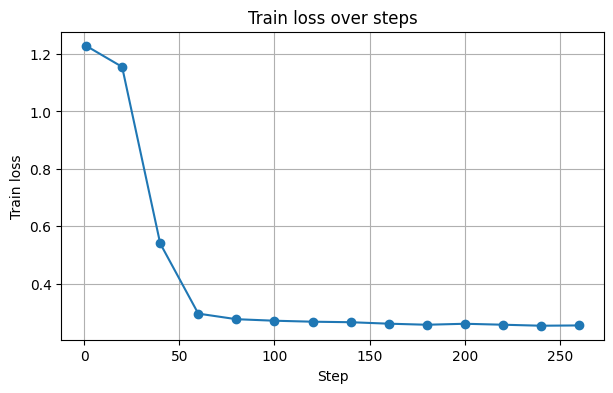

eval_loss column not found in logs.


In [21]:
import matplotlib.pyplot as plt

# TRAIN LOSS
train_logs = logs[logs["loss"].notnull()]

plt.figure(figsize=(7,4))
plt.plot(train_logs["step"], train_logs["loss"], marker="o")
plt.xlabel("Step")
plt.ylabel("Train loss")
plt.title("Train loss over steps")
plt.grid(True)
plt.show()

# EVAL LOSS (if present)
if "eval_loss" in logs.columns:
    eval_logs = logs[logs["eval_loss"].notnull()]
    if len(eval_logs) > 0:
        plt.figure(figsize=(7,4))
        plt.plot(eval_logs["step"], eval_logs["eval_loss"], marker="o", color="orange")
        plt.xlabel("Step")
        plt.ylabel("Eval loss")
        plt.title("Eval loss over steps")
        plt.grid(True)
        plt.show()
    else:
        print("No eval_loss logged.")
else:
    print("eval_loss column not found in logs.")


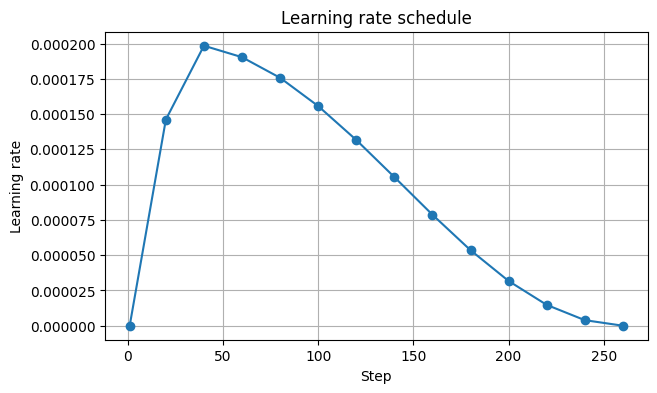

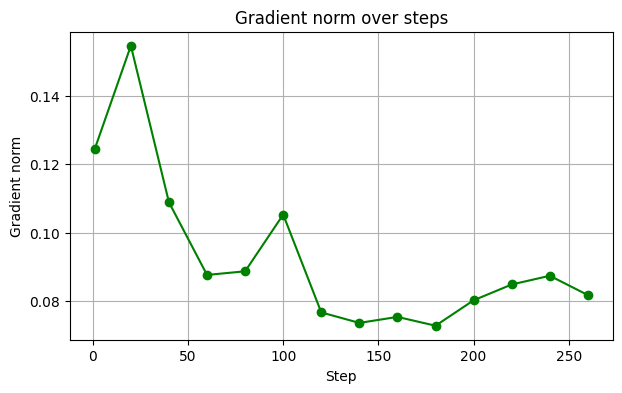

In [22]:
# LEARNING RATE
if "learning_rate" in logs.columns:
    lr_logs = logs[logs["learning_rate"].notnull()]
    if len(lr_logs) > 0:
        plt.figure(figsize=(7,4))
        plt.plot(lr_logs["step"], lr_logs["learning_rate"], marker="o")
        plt.xlabel("Step")
        plt.ylabel("Learning rate")
        plt.title("Learning rate schedule")
        plt.grid(True)
        plt.show()
    else:
        print("No learning_rate entries logged.")
else:
    print("learning_rate column not found in logs.")

# GRAD NORM
if "grad_norm" in logs.columns:
    gn_logs = logs[logs["grad_norm"].notnull()]
    if len(gn_logs) > 0:
        plt.figure(figsize=(7,4))
        plt.plot(gn_logs["step"], gn_logs["grad_norm"], marker="o", color="green")
        plt.xlabel("Step")
        plt.ylabel("Gradient norm")
        plt.title("Gradient norm over steps")
        plt.grid(True)
        plt.show()
    else:
        print("No grad_norm entries logged.")
else:
    print("grad_norm column not found in logs.")


In [23]:
# Reload fine-tuned model and test generation

from peft import PeftModel

# Reload 4-bit base model (reuse bnb_config from above)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

base_model.config.use_cache = False  # for safety

ft_model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
ft_model.eval()

print("Loaded fine-tuned model with LoRA adapter.")


def generate_milp_solution(problem_text: str, max_new_tokens: int = 1500, temperature: float = 0.0) -> str:
    user_message = problem_text["user_message"]
    prompt = (
        "<|im_start|>system\n"
        + SYSTEM_PROMPT
        + "<|im_end|>\n"
        "<|im_start|>user\n"
        +  user_message
        + "<|im_end|>\n"
        "<|im_start|>assistant\n"
    )
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH,   # same MAX_LENGTH you used for training
        padding=False).to(ft_model.device)

    bad_tokens = []
    bad_ids = []
    for tok in bad_tokens:
        try:
            bad_ids.append([tokenizer.encode(tok, add_special_tokens=False)[0]])
        except Exception:
            pass  # some tokens might be multi-token, ignore for now

    # eos_id = tokenizer.convert_tokens_to_ids("<|im_end|>")

    with torch.no_grad():
        output = ft_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=(temperature > 0),
            # bad_words_ids=bad_ids if bad_ids else None,
            temperature=0.0,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            repetition_penalty=1.1,
        )
    return tokenizer.decode(output[0], skip_special_tokens=False)

# Take one example from the raw dataset
TEST_DATA_PATH =  "/content/drive/MyDrive/Energy Arbitrage Agentics/dataset_qwen_train.jsonl"
raw_dataset_test = load_dataset(
    "json",
    data_files={"test": TEST_DATA_PATH},
)["test"]

sample_problem = raw_dataset_test[0]
print("=== PROBLEM (truncated) ===")
print(sample_problem, "...\n")

# print("=== MODEL OUTPUT ===")
# print(generate_milp_solution(sample_problem))


Loaded fine-tuned model with LoRA adapter.


Generating test split: 0 examples [00:00, ? examples/s]

=== PROBLEM (truncated) ===
{'date': datetime.datetime(2018, 1, 1, 0, 0), 'user_message': '{"capacity_MWh":49.44,"max_c_MW":12.36,"max_d_MW":12.36,"eta_c":0.95,"eta_d":0.95,"soc0":0.5,"soc_min":0.0,"soc_max":1.0,"dt_hours":1.0,"allow_export":true,"prices_buy":[45.82,44.16,42.24,39.29,36.0,41.99,42.25,44.97,45.0,44.94,45.02,45.71,46.7,43.98,44.96,47.53,49.91,54.3,51.91,51.38,49.2,45.73,44.84,38.11],"prices_sell":[45.82,44.16,42.24,39.29,36.0,41.99,42.25,44.97,45.0,44.94,45.02,45.71,46.7,43.98,44.96,47.53,49.91,54.3,51.91,51.38,49.2,45.73,44.84,38.11],"demand_MW":[22.98,21.81,20.76,19.97,19.49,19.84,21.1,22.1,22.4,23.59,24.37,24.96,25.06,23.9,23.49,23.76,25.24,29.1,30.35,30.97,30.34,28.82,26.54,24.05]}', 'assistant_message': '{"soc":[0.5,0.5,0.5,0.5,0.7375,0.9750000000000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7894736842105263,0.5263157894736842,0.2631578947368421,0.0,0.0,0.0,0.0,0.0],"cost":25278.39562}'} ...



In [24]:
# ast.literal_eval(sample_problem["user_message"])
import json
sample_prob_dict = json.loads(sample_problem["user_message"])
# sample_problem["user_message"]
sample_prob_dict["soc0"] = 0.5

In [25]:
sample_problem["user_message"] = str(sample_prob_dict)

In [26]:
sample_problem

{'date': datetime.datetime(2018, 1, 1, 0, 0),
 'user_message': "{'capacity_MWh': 49.44, 'max_c_MW': 12.36, 'max_d_MW': 12.36, 'eta_c': 0.95, 'eta_d': 0.95, 'soc0': 0.5, 'soc_min': 0.0, 'soc_max': 1.0, 'dt_hours': 1.0, 'allow_export': True, 'prices_buy': [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], 'prices_sell': [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], 'demand_MW': [22.98, 21.81, 20.76, 19.97, 19.49, 19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34, 28.82, 26.54, 24.05]}",
 'assistant_message': '{"soc":[0.5,0.5,0.5,0.5,0.7375,0.9750000000000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.7894736842105263,0.5263157894736842,0.2631578947368421,0.0,0.0,0.0,0.0,0.0],"cost":25278.39562}'}

In [27]:
import re, json

def extract_json_from_assistant(text: str):
    # 1) Get everything after <|im_start|>assistant
    marker = "<|im_start|>assistant"
    idx = text.find(marker)
    if idx == -1:
        raise ValueError("No assistant block found.")
    after = text[idx + len(marker):]

    # 2) Grab the FIRST JSON object in that text
    #    This regex finds the first {...} block (non-greedy)
    m = re.search(r"\{.*?\}", after, flags=re.DOTALL)
    if not m:
        raise ValueError("No JSON object found in assistant block.")

    json_str = m.group(0)
    return json.loads(json_str)

model_text = generate_milp_solution(sample_problem, max_new_tokens=1500, temperature=0.0)
try:
    pred_solution = extract_json_from_assistant(model_text)
    print("=== MODEL SOLUTION ===")
    print(pred_solution)
except Exception as e:
    print("Failed to parse JSON:", e)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== MODEL SOLUTION ===
{'soc': [0.5, 0.2375, 0.0, 0.0, 0.0, 0.2375, 0.475, 0.7124999999999999, 0.95, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.736842105263158, 0.4736842105263159, 0.21052631578947378, 0.0, 0.0, 0.0, 0.0], 'cost': 33004.600000000006}


In [28]:
print(model_text)

<|im_start|>system
You are a battery arbitrage optimization engine that exactly emulates the following mixed-integer linear program (MILP).

Given data:
- prices_buy[t]  : buy price at time t  (EUR/MWh)
- prices_sell[t] : sell price at time t (EUR/MWh), or equal to prices_buy[t] if missing
- demand_MW[t]   : exogenous load at time t (MW)
- capacity_MWh: energy capacity of the battery (MWh)
- max_c_MW: maximum charge power (MW)
- max_d_MW: maximum discharge power (MW)
- eta_c: charge efficiency
- eta_d: discharge efficiency
- soc0: initial SoC (fraction of capacity, between 0 and 1)
- soc_min, soc_max: SoC limits (fractions, between 0 and 1)
- dt_hours: time step length in hours
- allow_export: whether the battery can export to the grid

Horizon:
- There are T time steps, indexed t = 0,...,T-1, where T = 24 currently.
- Each step has length dt_hours (in hours), which is 1 currently.

Decision variables (for each t = 0,...,T-1):
- c[t]   >= 0 : charge power (MW)
- d[t]   >= 0 : discharge

In [29]:
print("eos_token_id:", tokenizer.eos_token_id)
print("im_end id:", tokenizer.convert_tokens_to_ids("<|im_end|>"))

eos_token_id: 151643
im_end id: 151645


In [30]:
len(pred_solution["soc"]), sample_problem["user_message"]

(24,
 "{'capacity_MWh': 49.44, 'max_c_MW': 12.36, 'max_d_MW': 12.36, 'eta_c': 0.95, 'eta_d': 0.95, 'soc0': 0.5, 'soc_min': 0.0, 'soc_max': 1.0, 'dt_hours': 1.0, 'allow_export': True, 'prices_buy': [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], 'prices_sell': [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], 'demand_MW': [22.98, 21.81, 20.76, 19.97, 19.49, 19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34, 28.82, 26.54, 24.05]}")

In [33]:
len(pred_solution["soc"])

24

In [35]:
from typing import Sequence, Optional
import json
def cost_from_soc(
    soc: Sequence[float],
    prices_buy: Sequence[float],
    demand_MW: Sequence[float],
    *,
    battery,
    prices_sell: Optional[Sequence[float]] = None,
    allow_export: bool = False,
    dt_hours: float = 1.0,
):
    soc = np.asarray(soc, dtype=float)
    if len(soc) <=24:
      soc = np.insert(soc, -1, 0.0)
    assert len(soc) >= 2, "SOC must include at least t=0 and t=1"
    T = len(soc) - 1
    # T = len(soc)

    prices_buy  = np.asarray(prices_buy, dtype=float)
    demand_MW   = np.asarray(demand_MW, dtype=float)
    print(len(prices_buy))
    print(len(demand_MW))
    print(len(soc))
    assert len(prices_buy) == T and len(demand_MW) == T

    if prices_sell is None:
        prices_sell = prices_buy
    prices_sell = np.asarray(prices_sell, dtype=float)
    assert len(prices_sell) == T

    # Per-step energy change in MWh
    dE = (soc[1:] - soc[:-1]) * battery["capacity_MWh"]

    # Recover charge/discharge MW from SOC deltas and efficiencies
    charge_MW    = np.maximum(dE, 0.0) / (battery["eta_c"] * dt_hours)
    discharge_MW = np.maximum(-dE, 0.0) * (battery["eta_d"] / dt_hours)

    # Enforce hardware limits
    charge_MW    = np.minimum(charge_MW,    battery["max_c_MW"])
    discharge_MW = np.minimum(discharge_MW, battery["max_d_MW"])

    # Grid net load
    net = demand_MW + charge_MW - discharge_MW
    imp = np.maximum(net, 0.0)
    exp = np.maximum(-net, 0.0) if allow_export else np.zeros_like(net)

    # Cost (buy imports, optionally credit exports)
    cost = float(np.sum(prices_buy * imp * dt_hours) - np.sum(prices_sell * exp * dt_hours))

    out = {
        "charge_MW": charge_MW,
        "discharge_MW": discharge_MW,
        "import_MW": imp,
        "export_MW": exp,
        "net_MW": net,
        "objective_cost": cost,
    }
    return out

# u = json.loads(sample_problem["user_message"])
u = ast.literal_eval(sample_problem["user_message"])


battery = {
    "capacity_MWh" : u["capacity_MWh"],
    "max_c_MW" : u["max_c_MW"],
    "max_d_MW" : u["max_d_MW"],
    "eta_c" : u["eta_c"],
    "eta_d" : u["eta_d"],
    "soc0" : u["soc0"],
    "soc_min" : u["soc_min"],
    "soc_max" : u["soc_max"],
}

out = cost_from_soc(
    soc = pred_solution["soc"],
    prices_buy=u["prices_buy"],
    demand_MW=u["demand_MW"],
    battery=battery,
    prices_sell=u["prices_sell"],
    allow_export=u["allow_export"],
    dt_hours=u["dt_hours"]
)
out["objective_cost"]

24
24
25


25398.228324526317

In [36]:
answer = json.loads(sample_problem["assistant_message"])
answer["cost"]

25278.39562

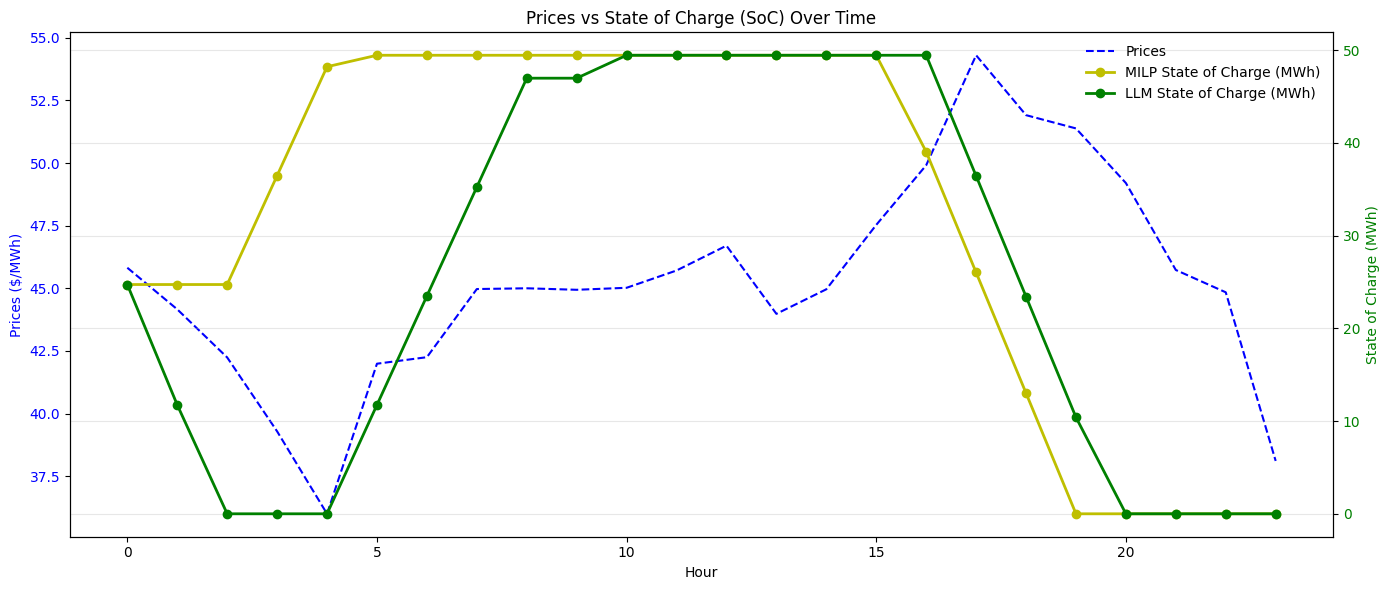

In [38]:
hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, u["prices_buy"], '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(answer["soc"][1:]) * battery["capacity_MWh"],
         '-oy', label='MILP State of Charge (MWh)', linewidth=2, markersize=6)
ax2.plot(hours, np.array(pred_solution["soc"][:]) * battery["capacity_MWh"],
         '-og', label='LLM State of Charge (MWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (MWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import numpy as np
import os

T = len(u["prices_buy"])  # or len(u["demand_MW"])

df = pd.DataFrame({
    "prices_actual":    np.asarray(u["prices_buy"], dtype=float),
    "actual_demand":    np.asarray(u["demand_MW"], dtype=float),
    "soc":              np.asarray(pred_solution["soc"][:], dtype=float),  # drop t=0

    # Convert MW → kW
    "charge_kw":        out["charge_MW"] * 1000.0,
    "discharge_kw":     out["discharge_MW"] * 1000.0,
    "import_kw":        out["import_MW"] * 1000.0,
    "export_kw":        out["export_MW"] * 1000.0,
})

# Sanity check lengths
print(df.shape)
display(df.head())

# Save to CSV
save_dir = "/content/drive/MyDrive/Energy Arbitrage Agentics/"
os.makedirs(save_dir, exist_ok=True)
csv_path = os.path.join(save_dir, "battery_schedule_results_Ollama.csv")
df.to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)


(24, 7)


,prices_actual,actual_demand,soc,charge_kw,discharge_kw,import_kw,export_kw
0,45.82,22.98,0.5000,0.0,12329.1,10650.9,0.0
1,44.16,21.81,0.2375,0.0,11154.9,10655.1,0.0
2,42.24,20.76,0.0000,0.0,0.0,20760.0,0.0
3,39.29,19.97,0.0000,0.0,0.0,19970.0,0.0
4,36.00,19.49,0.0000,12360.0,0.0,31850.0,0.0


Saved CSV to: /content/drive/MyDrive/Energy Arbitrage Agentics/battery_schedule_results_Ollama.csv


In [41]:
MERGED_DIR = "/content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_merged"  # where to save merged model

# Choose dtype: fp16 is standard for 7B on T4
DTYPE = torch.float16

# Put model on GPU if available; otherwise CPU (slower but works)
if torch.cuda.is_available():
    device_map = {"": 0}  # put everything on cuda:0
else:
    device_map = None     # full model on CPU

print("Using device_map:", device_map)

# 1. Load base model (IMPORTANT: no 4-bit / quantization when merging)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=DTYPE,        # keep weights in fp16
    device_map=device_map,    # "auto" or explicit; we use explicit
    trust_remote_code=True,   # needed for Qwen
    low_cpu_mem_usage=True,   # helps in Colab to reduce RAM pressure
)

# 2. Attach your LoRA adapter (the fine-tuned weights)
model = PeftModel.from_pretrained(
    base_model,
    OUTPUT_DIR,
    torch_dtype=DTYPE,
    is_trainable=False,       # we're only merging, not training
)

# 3. Merge LoRA weights into the base model
#    After this, 'model' is a plain HF model (no PEFT wrapper)
model = model.merge_and_unload()

# Optional but nice: ensure generation config is consistent
model.config.use_cache = True
model.config.torch_dtype = DTYPE

# 4. Save merged model + tokenizer in standard HF format
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Save tokenizer
tokenizer.save_pretrained(MERGED_DIR)

# safe_serialization=True -> saves as .safetensors (better for later conversion)
model.save_pretrained(
    MERGED_DIR,
    safe_serialization=True,
)
tokenizer.save_pretrained(MERGED_DIR)

print("Merged model saved to:", MERGED_DIR)


`torch_dtype` is deprecated! Use `dtype` instead!


Using device_map: {'': 0}
Merged model saved to: /content/drive/MyDrive/Energy Arbitrage Agentics/qwen_math_milp_merged


In [42]:
#Clone llama.cpp in Colab
%cd /content
!rm -rf llama.cpp  # just in case you already cloned it
!git clone https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp

/content
Cloning into 'llama.cpp'...
remote: Enumerating objects: 69588, done.
remote: Total 69588 (delta 0), reused 0 (delta 0), pack-reused 69588 (from 1)
Receiving objects: 100% (69588/69588), 211.18 MiB | 43.30 MiB/s, done.
Resolving deltas: 100% (50452/50452), done.
/content/llama.cpp


In [43]:
#This installs the Python packages needed by convert-hf-to-gguf.py (like transformers, etc).
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 135.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.0 MB/s eta 0:00:00
ERRO

In [44]:
%cd /content/llama.cpp
!python convert_hf_to_gguf.py -h

/content/llama.cpp
usage: convert_hf_to_gguf.py [-h] [--vocab-only] [--outfile OUTFILE]
                             [--outtype {f32,f16,bf16,q8_0,tq1_0,tq2_0,auto}]
                             [--bigendian] [--use-temp-file] [--no-lazy]
                             [--model-name MODEL_NAME] [--verbose]
                             [--split-max-tensors SPLIT_MAX_TENSORS]
                             [--split-max-size SPLIT_MAX_SIZE] [--dry-run]
                             [--no-tensor-first-split] [--metadata METADATA]
                             [--print-supported-models] [--remote] [--mmproj]
                             [--mistral-format]
                             [--disable-mistral-community-chat-template]
                             [--sentence-transformers-dense-modules]
                             [model]

Convert a huggingface model to a GGML compatible file

positional arguments:
  model                 directory containing model file or huggingface
                   

In [45]:
GGUF_OUT = "/content/drive/MyDrive/Energy Arbitrage Agentics/qwen-milp-q4.gguf"

In [46]:
%cd /content/llama.cpp

!python convert_hf_to_gguf.py \
  "{MERGED_DIR}" \
  --outfile "{GGUF_OUT}" \
  --outtype q8_0

/content/llama.cpp
INFO:hf-to-gguf:Loading model: qwen_math_milp_merged
INFO:hf-to-gguf:Model architecture: Qwen2ForCausalLM
INFO:hf-to-gguf:gguf: indexing model part 'model.safetensors'
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:token_embd.weight,         torch.float16 --> Q8_0, shape = {1536, 151936}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.float16 --> F32, shape = {1536}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.float16 --> Q8_0, shape = {8960, 1536}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.float16 --> Q8_0, shape = {1536, 8960}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.float16 --> Q8_0, shape = {1536, 8960}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.float16 --> F32, shape = {1536}
INFO:hf-to-gguf:blk.0.attn_k.bias,         torch.float16 --> F32, shape = {256}
INFO:hf-to-gguf:blk.0.attn_k.weight,       torch.float16 --> Q8_0, shape = {1536, 256}
INFO:hf-to-gguf:blk.0.attn

In [47]:
import os

print("File exists:", os.path.exists(GGUF_OUT))
if os.path.exists(GGUF_OUT):
    print("Size (MB):", os.path.getsize(GGUF_OUT) / (1024 * 1024))

File exists: True
Size (MB): 1570.2938537597656
